# LSTM Baseline Model Testing

## 0 Imports & Constants

In [26]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from utils import load_complete_time_series, split_data_into_sequences
from LSTM import LSTM, train_model, scale_data, train_test_split_to_tensor, inverse_scale_data
from TimeSeriesDataset import TimeSeriesDataset

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [29]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = True

### Hyperparameters

In [30]:
SEQ_LEN = 14
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [31]:
FEATURES = ['Close', 'Volume']
NUM_FEATURES_PER_TIME_STEP = len(FEATURES)
FEATURES_INCL_DATE = FEATURES + ['Date']

## 2 Data

### Data Loading

In [32]:
# Load data from csv
# -> convert Date column to datetime
data = load_complete_time_series(f'{REAL_DATA_FOLDER}/AAPL_10_24_real.csv')
data = data[FEATURES_INCL_DATE] # remember to put the target column first
data[10:]

,Close,Volume,Date
10,7.680000,730007600,2010-01-19
11,7.561786,612152800,2010-01-20
12,7.431071,608154400,2010-01-21
13,7.062500,881767600,2010-01-22
14,7.252500,1065699600,2010-01-25
...,...,...,...
3613,186.279999,72044800,2024-05-13
3614,187.429993,52393600,2024-05-14
3615,189.720001,70400000,2024-05-15
3616,189.839996,52800800,2024-05-16


### Data Preprocessing

In [33]:
shifted_np_array = split_data_into_sequences(data, SEQ_LEN)

Shape of the data after splitting into sequences: (3604, 14, 2)


In [35]:
shifted_np_array, scaler_close = scale_data(shifted_np_array)

array([[[0.00410081, 0.25293162],
        [0.00416991, 0.31118587],
        [0.00353313, 0.28439742],
        ...,
        [0.00367505, 0.31670459],
        [0.00299158, 0.31455138],
        [0.00106442, 0.46189689]],

       [[0.00416991, 0.31118587],
        [0.00353313, 0.28439742],
        [0.00346029, 0.24399309],
        ...,
        [0.00299158, 0.31455138],
        [0.00106442, 0.46189689],
        [0.00205788, 0.5609475 ]],

       [[0.00353313, 0.28439742],
        [0.00346029, 0.24399309],
        [0.00372173, 0.22809584],
        ...,
        [0.00106442, 0.46189689],
        [0.00205788, 0.5609475 ],
        [0.00259382, 0.99252107]],

       ...,

       [[0.85244526, 0.0142761 ],
        [0.84936033, 0.01119583],
        [0.87132098, 0.02375999],
        ...,
        [0.92125535, 0.01438445],
        [0.93814413, 0.02584696],
        [0.94415713, 0.01526444]],

       [[0.84936033, 0.01119583],
        [0.87132098, 0.02375999],
        [0.85474592, 0.02255662],
        .

In [36]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(shifted_np_array)


Shape of X_train: torch.Size([3423, 13, 2]) 
 Shape of y_train: torch.Size([3423, 1]) 
 Shape of X_test: torch.Size([181, 13, 2]) 
 Shape of y_test: torch.Size([181, 1])


In [12]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 13, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [15]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=NUM_FEATURES_PER_TIME_STEP,
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()

In [17]:
best_validation_loss, model = train_model(model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device)

Epoch: 1
Validation Loss: 0.0008414179901592433
**************************************************
Epoch: 2
Validation Loss: 0.0015643741838478793
INFO: Validation loss did not improve in epoch 2
**************************************************
Epoch: 3
Validation Loss: 0.0019550360060141734
INFO: Validation loss did not improve in epoch 3
**************************************************
Epoch: 4
Validation Loss: 0.0017049483576556668
INFO: Validation loss did not improve in epoch 4
**************************************************
Epoch: 5
Validation Loss: 0.0017682789087605972
INFO: Validation loss did not improve in epoch 5
**************************************************
Epoch: 6
Validation Loss: 0.0021151628219134486
INFO: Validation loss did not improve in epoch 6
**************************************************
Epoch: 7
Validation Loss: 0.00173340123728849
INFO: Validation loss did not improve in epoch 7
**************************************************
Epoch: 8
Valida

## 4 Plot Predictions

### Inverse Transform

In [19]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [20]:
test_pred = inverse_scale_data(test_pred, scaler_close, SEQ_LEN)
train_pred = inverse_scale_data(train_pred, scaler_close, SEQ_LEN)
y_test = inverse_scale_data(y_test, scaler_close, SEQ_LEN)
y_train = inverse_scale_data(y_train, scaler_close, SEQ_LEN)

Shape of the inverse scaled numpy array: (181,)
Shape of the inverse scaled numpy array: (3423,)
Shape of the inverse scaled numpy array: (181,)
Shape of the inverse scaled numpy array: (3423,)


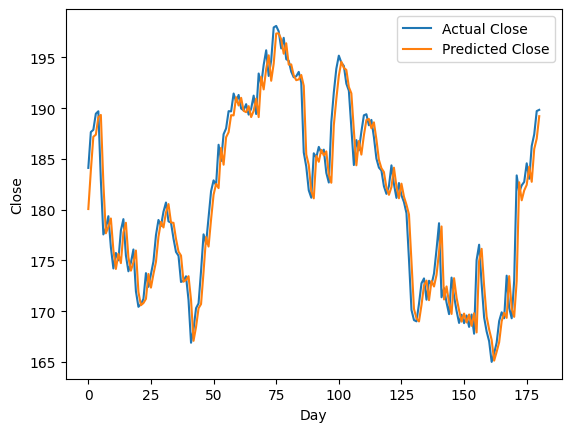

In [21]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


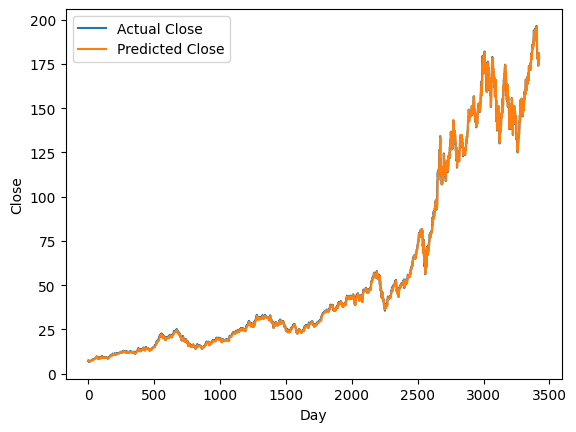

In [22]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()
